# 量子誤り訂正のシミュレーションチュートリアル
## 量子ビットに発生するエラーの表現
量子ビットに発生するエラーはエラーがないIとX,Y,Zの合わせて4種類であり、Yエラーは、XとZエラーが両方発生していることに対応するので、XとZエラーそれぞれに1bitの情報を用いて表現することができる

In [1]:
#1つ目の要素がXエラーで2つ目の要素がZエラー
num_qubit = 20
qubit = [0,0,num_qubit]

In [2]:
def show_errors(qubit):
    bit_length = '{:0'+str(qubit[-1])+'b}'
    print( bit_length.format(qubit[0]),'||',bit_length.format(qubit[1]))
    
def initialize(qubit):
    qubit[0]=0
    qubit[1]=0

In [3]:
show_errors(qubit)

00000000000000000000 || 00000000000000000000


# エラーの発生
エラーの発生はノイズモデルにもよるがここでは各量子ビットに独立にX,Y,Zエラーが確率p/3で発生するdepolarizing noiseについて説明す。

In [4]:
#例えば3番目の量子ビットにXエラーを発生
initialize(qubit)
qubit[0]^= pow(2,3)

In [5]:
show_errors(qubit)

00000000000000001000 || 00000000000000000000


In [6]:
def x_error(qubit,i):
    qubit[0]^= pow(2,i)

def y_error(qubit,i):
    qubit[0]^= pow(2,i)    
    qubit[1]^= pow(2,i)

def z_error(qubit,i):
    qubit[1]^= pow(2,i)

In [7]:
initialize(qubit)
y_error(qubit,0)
show_errors(qubit)

z_error(qubit,9)
show_errors(qubit)

00000000000000000001 || 00000000000000000001
00000000000000000001 || 00000000001000000001


確率pに基づいて　i 番目の量子ビットにdepolarizing errorを発生させる関数を定義する。

In [8]:
import random 

def single_depolarizing(qubit,i,p):
    prob = random.random()

    if prob < p/3: #X error
        x_error(qubit,i)
        
    elif prob < 2*p/3: #Z error
        z_error(qubit,i)
        
    elif prob < p: # Y error
        y_error(qubit,i)

In [9]:
initialize(qubit)
for i in range(num_qubit):
    error_prob = 0.2
    single_depolarizing(qubit,i,error_prob)
show_errors(qubit)

00001001000000000000 || 00000001001000000000


# エラーに対する量子ゲートの作用
Cliffordゲート（アダマールゲート、CNOTゲート、CZゲート）の作用はX,Y,Zエラーを表すビット列の変換で記述される。

In [10]:
# i番目のビット列を取得
def get_bit(bit,i):
    tmp = bit
    return (tmp >> i)%2

def bitmask(i):
    return pow(2,i)

# i番目にHadamard gateを作用させる
def H_gate(qubit,i):
    bm = bitmask(i)
    qubit[0]^=(qubit[1]&bm)
    qubit[1]^=(qubit[0]&bm)
    qubit[0]^=(qubit[1]&bm)

#i番目がcontrolビット j 番目がtargetビットのCNOTgate
def CNOT_gate(qubit,c,t):
    c_bm = bitmask(c)
    t_bm =  bitmask(t)
    qubit[0]^=t_bm*get_bit(qubit[0],c)
    qubit[1]^=c_bm*get_bit(qubit[1],t)


In [11]:
initialize(qubit)
for i in range(num_qubit):
    error_prob = 0.2
    single_depolarizing(qubit,i,error_prob)
show_errors(qubit)

for i in range(num_qubit):
    H_gate(qubit,i)
show_errors(qubit)

01100000100000100000 || 01000000010000100000
01000000010000100000 || 01100000100000100000


In [12]:
for i in range(num_qubit-1):
    CNOT_gate(qubit,i,i+1)
show_errors(qubit)

11000000001111100000 || 01010000110000110000


# １次元反復符号の誤り訂正

偶数番目の量子ビットをデータ量子ビットとして、奇数番目を隣あるビット列のパリティ検出に用いる補助量子ビットとする。
0...0と1...1の２つの符号状態を用いて計算する。エラーはビットエラーしか考えない。（いわゆる古典のエラー訂正を量子回路で考える）

In [13]:
code_distance = 11
num_qubit = code_distance*2 -1 
qubit = [0,0,num_qubit]

In [14]:
def bit_flip_error(qubit,i,p):
    prob = random.random()
    if prob < p:
        x_error(qubit,i)
        
def get_qubit_array(qubit):
    qubit_array = []
    for i in range(qubit[-1]):
        qubit_array.append(get_bit(qubit[0],i)*pow(0.5,i%2))
    return qubit_array
    

In [15]:
initialize(qubit)

for i in range(num_qubit):
    if i%2 == 0:
        bit_flip_error(qubit,i,0.3)
    
show_errors(qubit)

001010000000100000001 || 000000000000000000000


In [16]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]


<AxesSubplot:>

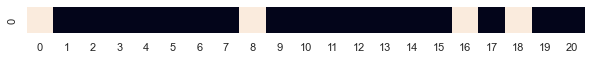

In [17]:
print(get_qubit_array(qubit))
sns.set(rc = {'figure.figsize':(10,0.5*num_qubit)})
sns.heatmap([get_qubit_array(qubit)],square=True,cbar=False)

<AxesSubplot:>

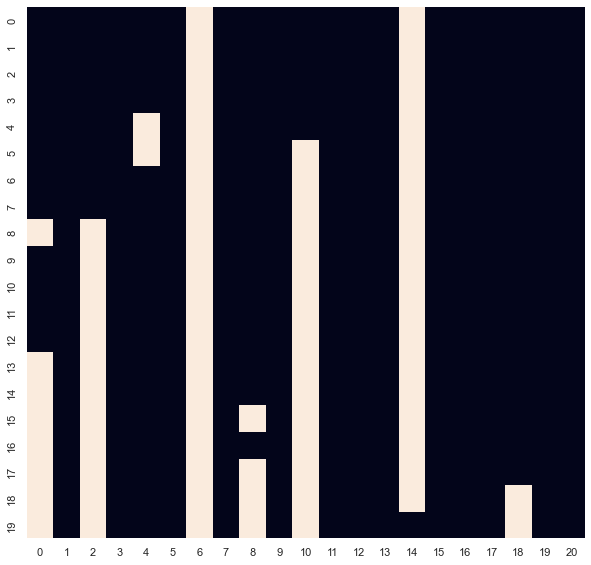

In [18]:
initialize(qubit)
cycle = 20
error_history = []
for j in range(cycle):
    
    for i in range(num_qubit):
        if i%2 == 0:
            bit_flip_error(qubit,i,0.1)
    error_history.append(get_qubit_array(qubit))

sns.set(rc = {'figure.figsize':(0.5*cycle,0.5*num_qubit)})
sns.heatmap(error_history,square=True,cbar=False)

奇数番目の量子ビットを使って両隣の量子ビットのパリティ検出を行う

In [19]:
def parity_check(qubit):
    # parity bitの初期化
    num_parity_bit = int((qubit[-1]+1)/2)
    data_bit_mask = sum([pow(2,2*i) for i in range(num_parity_bit+1)])
    qubit[0] &= data_bit_mask

    for i in range(num_parity_bit):
        parity_bit = 2*i+1
        CNOT_gate(qubit,parity_bit-1, parity_bit)
        CNOT_gate(qubit,parity_bit+1,parity_bit)

<AxesSubplot:>

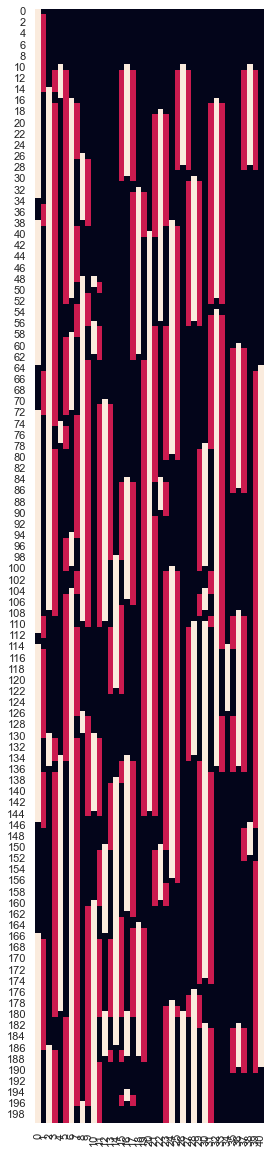

In [20]:
code_distance = 21
num_qubit = code_distance*2 -1 
qubit = [0,0,num_qubit]

initialize(qubit)
cycle = 100
error_history = []
for j in range(cycle):
    
    for i in range(num_qubit):
        if i%2 == 0:
            bit_flip_error(qubit,i,0.05)
            
    error_history.append(get_qubit_array(qubit))
    parity_check(qubit)
    error_history.append(get_qubit_array(qubit))


sns.set(rc = {'figure.figsize':(0.5*cycle,0.5*num_qubit)})
sns.heatmap(error_history,square=True,cbar=False)

エラーはある時刻に発生すると以降、状態に残り続けるので、パリティはずっとその結果を反映している。どの時刻でエラーが発生したかを知るためには、1つ前の時刻のパリティと次の時刻のパリティのXOR（差分）をとる必要がある。

## 差分パリティの定義

<AxesSubplot:>

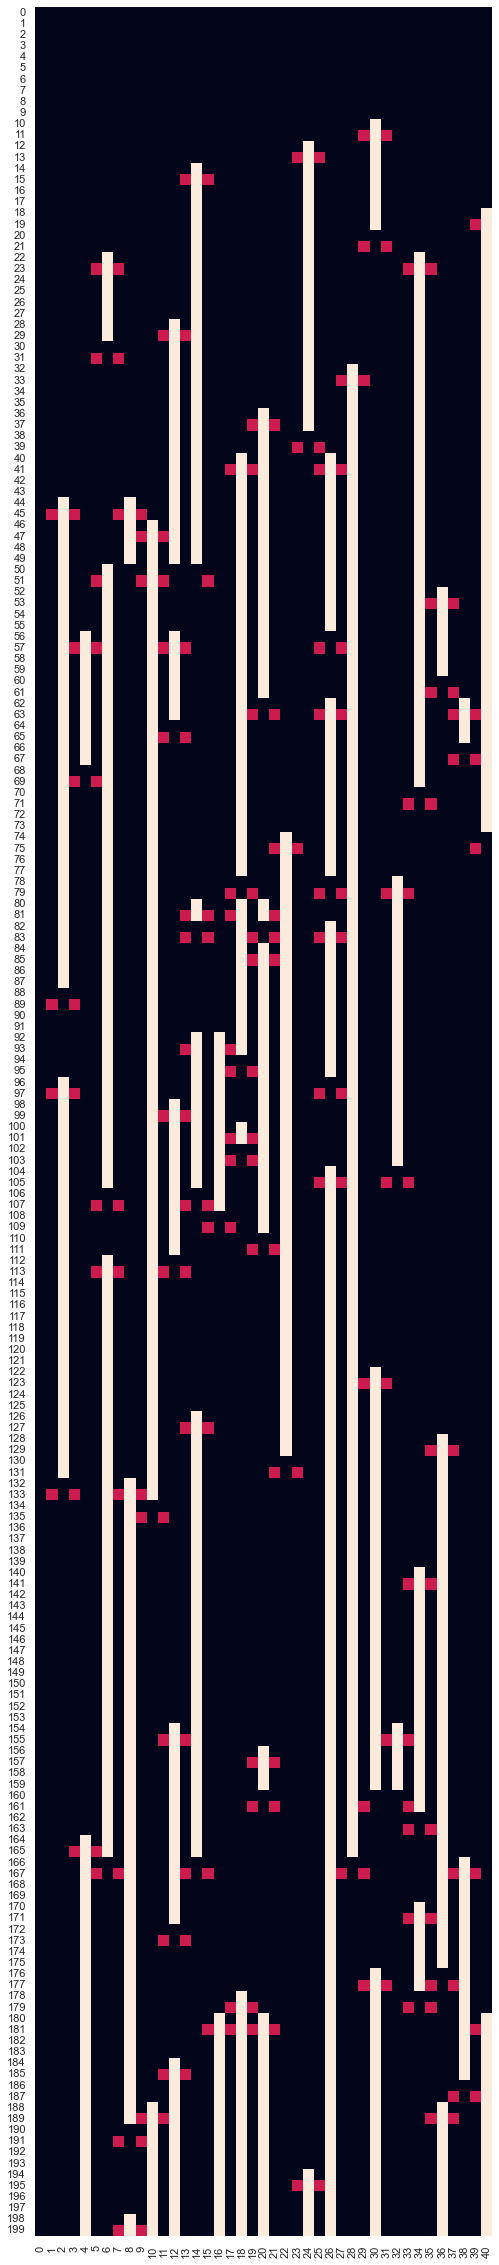

In [21]:
code_distance = 21
num_qubit = code_distance*2 -1 
qubit = [0,0,num_qubit]

num_parity_bit = int((qubit[-1]+1)/2)
parity_bit_mask = sum([pow(2,2*i+1) for i in range(num_parity_bit)])
data_bit_mask = sum([pow(2,2*i) for i in range(num_parity_bit+1)])

initialize(qubit)
cycle = 100
error_history = []
old_parity = 0

for j in range(cycle):
    for i in range(num_qubit):
        if i%2 == 0:
            bit_flip_error(qubit,i,0.05)

    qubit[0]&=data_bit_mask #この時点でパリティビットを描画したくないので初期化しておく
    error_history.append(get_qubit_array(qubit))
    
    
    parity_check(qubit)
    
    tmp = qubit[0]&parity_bit_mask
    qubit[0]^=old_parity
    old_parity = tmp 
    
    error_history.append(get_qubit_array(qubit))


sns.set(rc = {'figure.figsize':(cycle,num_qubit)})
sns.heatmap(error_history,square=True,cbar=False)

## パリティ検出のゲートにもエラーを導入
上記は、パリティ検出の時に使う、CNOTや補助量子ビットに格納されたパリティのビットを読み出す時にもエラーが発生するので、その効果も取り込む。

In [46]:
def noisy_parity_check(qubit,p):
    # parity bitの初期化
    num_parity_bit = int((qubit[-1]+1)/2)
    data_bit_mask = sum([pow(2,2*i) for i in range(num_parity_bit+1)])
    qubit[0] &= data_bit_mask

    for i in range(num_parity_bit):
        parity_bit = 2*i+1
        
        CNOT_gate(qubit,parity_bit-1, parity_bit)
        bit_flip_error(qubit,parity_bit,p)
        bit_flip_error(qubit,parity_bit-1,p)
        
        CNOT_gate(qubit,parity_bit+1,parity_bit)
        bit_flip_error(qubit,parity_bit,p)
        bit_flip_error(qubit,parity_bit+1,p)

        #readout error
        bit_flip_error(qubit,parity_bit,p)

<AxesSubplot:>

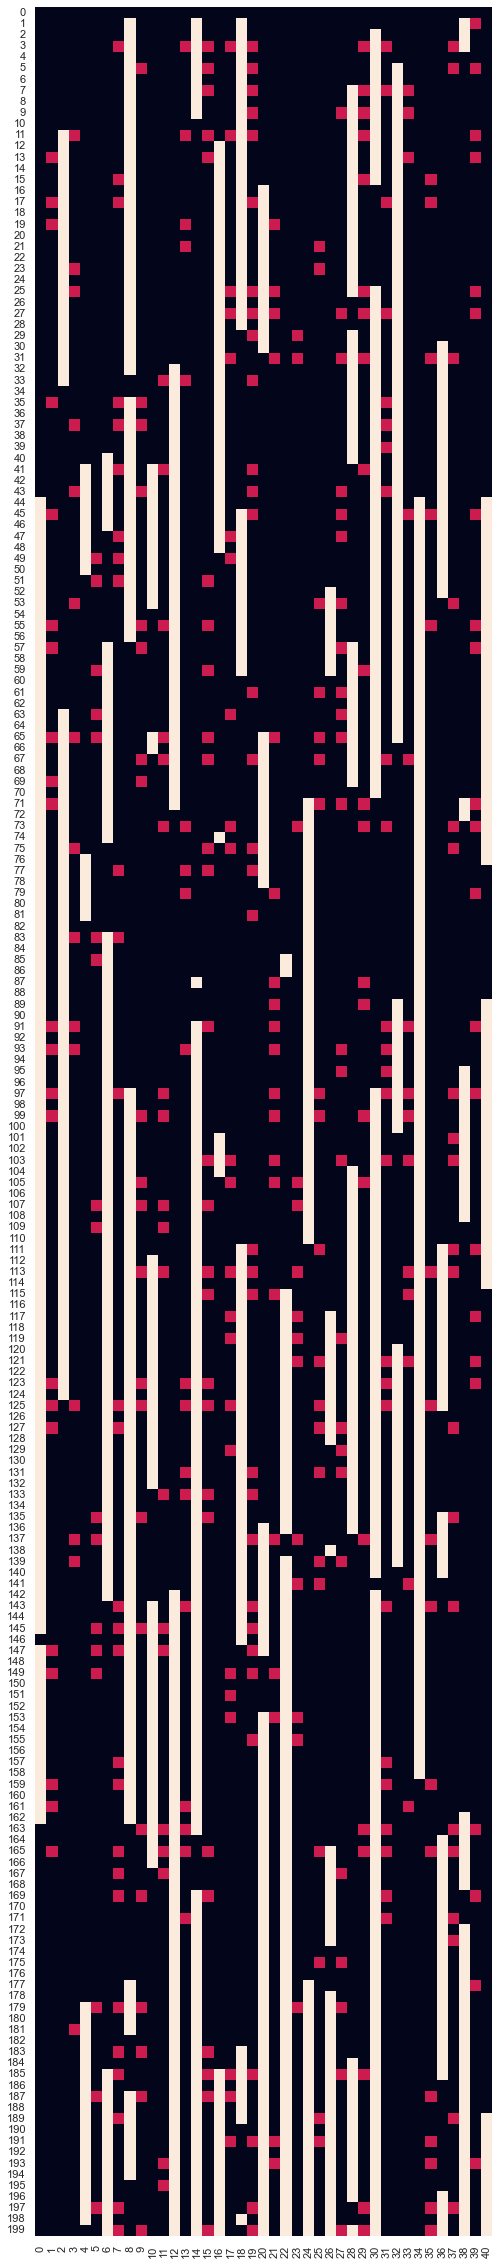

In [275]:
code_distance = 21
num_qubit = code_distance*2 -1 
qubit = [0,0,num_qubit]
error_prob = 0.02
num_parity_bit = int((qubit[-1]+1)/2)
parity_bit_mask = sum([pow(2,2*i+1) for i in range(num_parity_bit)])
data_bit_mask = sum([pow(2,2*i) for i in range(code_distance)])
cycle = 100

initialize(qubit)
error_history = []
old_parity = 0

for j in range(cycle):
    for i in range(num_qubit):
        #各ステップごとに発生するエラー
        if i%2 == 0:
            bit_flip_error(qubit,i,error_prob)
            
    qubit[0]&=data_bit_mask #この時点でパリティビットを描画したくないので初期化しておく
    error_history.append(get_qubit_array(qubit))
    
    noisy_parity_check(qubit,error_prob)
    
    tmp = qubit[0]&parity_bit_mask
    qubit[0]^=old_parity
    old_parity = tmp 
    
    error_history.append(get_qubit_array(qubit))


sns.set(rc = {'figure.figsize':(cycle,num_qubit)})
sns.heatmap(error_history,square=True,cbar=False)

## 完全マッチングを用いた復号
時空間で差分パリティを頂点とする完全マッチング問題を解けばよいことになる。
完全マッチング問題を解くために２つのグラフを導入する：
- decoder graph : 頂点が差分シンドローム、辺がエラー配置（一方がデータ量子ビット、一方が測定エラー）、古典エラー訂正でいうfactor graph。
- matching graph : 差分シンドロームが1の頂点から成る重み付きグラフ。重みは、decoder graphにおける最短距離。

### 差分シンドロームの取得

101000100000001000100 || 000000000000000000000


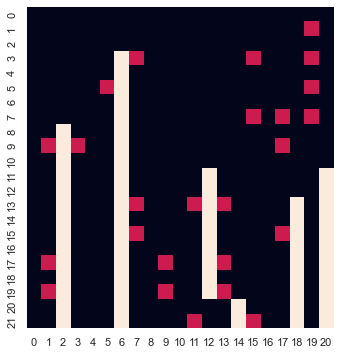

In [290]:
code_distance = 11
num_qubit = code_distance*2 -1 
qubit = [0,0,num_qubit]
error_prob = 0.02
num_parity_bit = code_distance-1
parity_bit_mask = sum([pow(2,2*i+1) for i in range(num_parity_bit)])
data_bit_mask = sum([pow(2,2*i) for i in range(code_distance)])
cycle = code_distance

edge_of_decoder_graph = []

initialize(qubit)
error_history = []
old_parity = 0

for j in range(cycle):
    for i in range(num_qubit):
        #各ステップごとに発生するエラー
        if i%2 == 0:
            bit_flip_error(qubit,i,error_prob)
            
    qubit[0]&=data_bit_mask #この時点でパリティビットを描画したくないので初期化しておく
    error_history.append(get_qubit_array(qubit))
    
    if j == cycle -1:
        parity_check(qubit)
    else:
        noisy_parity_check(qubit,error_prob)
    
    tmp = qubit[0]&parity_bit_mask
    qubit[0]^=old_parity
    old_parity = tmp 
    
    #networkXで扱うために差分シンドロームが1になっている頂点の情報をlistとして書き出す
    for k in range(num_parity_bit):
        if get_bit(qubit[0],2*k+1)==1:
            edge_of_decoder_graph.append((k,j))
    
    error_history.append(get_qubit_array(qubit))


sns.set(rc = {'figure.figsize':(0.5*cycle,0.5*num_qubit)})
sns.heatmap(error_history,square=True,cbar=False)

qubit[0]&=data_bit_mask #最後にdataに残っているエラーを知りたいのでパリティを初期化しておく
show_errors(qubit)
#print(edge_of_decoder_graph)

### Decoder graphの構成

In [291]:
import networkx as nx
import matplotlib.pyplot as plt

gp = nx.grid_graph(dim=[cycle,num_parity_bit],periodic=False)
#正方格子に外点を1つ加えておく（単点ではパリティを検出できないため、パリティoddになる頂点数が奇数になりうる）
gp.add_node('external')
for i in range(cycle):
    gp.add_edge('external',(0,i))
    gp.add_edge('external',(num_parity_bit-1,i))

#nx.draw_networkx(gp)
#plt.show()

In [292]:
#パリティoddの頂点数が奇数の場合は外点をdecoer graphに追加して頂点数を偶数に
if len(edge_of_decoder_graph)%2==1:
    edge_of_decoder_graph.append('external')
#print(edge_of_decoder_graph)

### Matching graphの構成（このグラフで完全マッチングを実行する）

In [293]:
mwpm_gp = nx.Graph() 
for i in range(len(edge_of_decoder_graph)):
        mwpm_gp.add_node(i)
    
for i in range(len(edge_of_decoder_graph)):
    for j in range(i):
        #shortest_path = nx.dijkstra_path(gp, edge_of_decoder_graph[i],edge_of_decoder_graph[j])
        shortest_path_weight = nx.dijkstra_path_length(gp, edge_of_decoder_graph[i],edge_of_decoder_graph[j])
        mwpm_gp.add_edge(i,j,weight = shortest_path_weight)
        #print(shortest_path_weight)
        
#nx.draw_networkx(mwpm_gp)
#plt.show()

### 完全マッチングを実行（ここの部分が一番重い、近似でもいい）

In [294]:
mwpm_res = nx.min_weight_matching(mwpm_gp)
match_path = []
for match_pair in mwpm_res:
    match_path.append(nx.dijkstra_path(gp,edge_of_decoder_graph[match_pair[0]],edge_of_decoder_graph[match_pair[1]]))
#print(match_path)

### マッチング結果から訂正操作

In [37]:
corrected_qubit = [0,0,num_qubit]
corrected_qubit[0] = qubit[0]
for path in match_path:
    #print(path)
    for i in range(len(path)):
        if i !=0:
            if path[i-1] == 'external':
                if path[i][0] ==0:
                    corrected_qubit[0]^= 1
                else:
                    corrected_qubit[0]^= pow(2,2*(code_distance-1))
                    
            elif path[i] == 'external':
                if path[i-1][0] ==0:
                    corrected_qubit[0]^= 1
                else:
                    corrected_qubit[0]^= pow(2,2*(code_distance-1))
            
            elif path[i-1][1] == path[i][1]:
                corrected_qubit[0]^= pow(2,2*(min(path[i-1][0],path[i][0])+1))
                
show_errors(qubit)            
show_errors(corrected_qubit)

000000100010100010001 || 000000000000000000000
000000000000000000000 || 000000000000000000000


## 論理エラー確率の評価
これらをまとめて、エラー確率に対して論理エラー確率がどのように振る舞うかしらべてみる。

In [79]:
import random 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# i番目のビット列を取得
def get_bit(bit,i):
    tmp = bit
    return (tmp >> i)%2

def bitmask(i):
    return pow(2,i)

# i番目にHadamard gateを作用させる
def H_gate(qubit,i):
    bm = bitmask(i)
    qubit[0]^=(qubit[1]&bm)
    qubit[1]^=(qubit[0]&bm)
    qubit[0]^=(qubit[1]&bm)

#i番目がcontrolビット j 番目がtargetビットのCNOTgate
def CNOT_gate(qubit,c,t):
    c_bm = bitmask(c)
    t_bm =  bitmask(t)
    qubit[0]^=t_bm*get_bit(qubit[0],c)
    qubit[1]^=c_bm*get_bit(qubit[1],t)
    
def x_error(qubit,i):
    qubit[0]^= pow(2,i)

def y_error(qubit,i):
    qubit[0]^= pow(2,i)    
    qubit[1]^= pow(2,i)

def z_error(qubit,i):
    qubit[1]^= pow(2,i)
def show_errors(qubit):
    bit_length = '{:0'+str(qubit[-1])+'b}'
    print( bit_length.format(qubit[0]),'||',bit_length.format(qubit[1]))
    
def initialize(qubit):
    qubit[0]=0
    qubit[1]=0

def bit_flip_error(qubit,i,p):
    prob = random.random()
    if prob < p:
        x_error(qubit,i)
        
def get_qubit_array(qubit):
    qubit_array = []
    for i in range(qubit[-1]):
        qubit_array.append(get_bit(qubit[0],i)*pow(0.5,i%2))
    return qubit_array
    
def noisy_parity_check(qubit,p):
    # parity bitの初期化
    num_parity_bit = int((qubit[-1]+1)/2)
    data_bit_mask = sum([pow(2,2*i) for i in range(num_parity_bit+1)])
    qubit[0] &= data_bit_mask

    for i in range(num_parity_bit):
        parity_bit = 2*i+1
        
        CNOT_gate(qubit,parity_bit-1, parity_bit)
        bit_flip_error(qubit,parity_bit,p)
        bit_flip_error(qubit,parity_bit-1,p)
        
        CNOT_gate(qubit,parity_bit+1,parity_bit)
        bit_flip_error(qubit,parity_bit,p)
        bit_flip_error(qubit,parity_bit+1,p)

        #readout error
        bit_flip_error(qubit,parity_bit,p)
        
def parity_check(qubit):
    # parity bitの初期化
    num_parity_bit = int((qubit[-1]+1)/2)
    data_bit_mask = sum([pow(2,2*i) for i in range(num_parity_bit+1)])
    qubit[0] &= data_bit_mask

    for i in range(num_parity_bit):
        parity_bit = 2*i+1
        CNOT_gate(qubit,parity_bit-1, parity_bit)
        CNOT_gate(qubit,parity_bit+1,parity_bit)
        
##########
code_distance_list = [3,5,7,9,11,13]
#error_prob = 0.05
error_prob_list = [0.005+i*0.005 for i in range(12)]
samples = 10000
##########



cd =0
result = [[] for i in range(len(code_distance_list))]
    
for code_distance in code_distance_list:

    num_qubit = code_distance*2 -1 
    qubit = [0,0,num_qubit]
    num_parity_bit = code_distance-1
    parity_bit_mask = sum([pow(2,2*i+1) for i in range(num_parity_bit)])
    data_bit_mask = sum([pow(2,2*i) for i in range(code_distance)])
    cycle = code_distance

    
    for error_prob in error_prob_list:

        logi_error_prob = 0


        for san in range(samples):

            edge_of_decoder_graph = []
            initialize(qubit)
            error_history = []
            old_parity = 0

            for j in range(cycle):
                for i in range(num_qubit):
                    #各ステップごとに発生するエラー
                    if i%2 == 0:
                        bit_flip_error(qubit,i,error_prob)

                qubit[0]&=data_bit_mask #この時点でパリティビットを描画したくないので初期化しておく
                error_history.append(get_qubit_array(qubit))

                if j == cycle -1:
                    parity_check(qubit)
                else:
                    noisy_parity_check(qubit,error_prob)

                tmp = qubit[0]&parity_bit_mask
                qubit[0]^=old_parity
                old_parity = tmp 

                #networkXで扱うために差分シンドロームが1になっている頂点の情報をlistとして書き出す
                for k in range(num_parity_bit):
                    if get_bit(qubit[0],2*k+1)==1:
                        edge_of_decoder_graph.append((k,j))

                error_history.append(get_qubit_array(qubit))


            #sns.set(rc = {'figure.figsize':(0.5*cycle,0.5*num_qubit)})
           # sns.heatmap(error_history,square=True,cbar=False)

            qubit[0]&=data_bit_mask #最後にdataに残っているエラーを知りたいのでパリティを初期化しておく
            #show_errors(qubit)
            #print(edge_of_decoder_graph)


            gp = nx.grid_graph(dim=[cycle,num_parity_bit],periodic=False)
            #正方格子に外点を1つ加えておく（単点ではパリティを検出できないため、パリティoddになる頂点数が奇数になりうる）
            gp.add_node('external')
            for i in range(cycle):
                gp.add_edge('external',(0,i))
                gp.add_edge('external',(num_parity_bit-1,i))

            #nx.draw_networkx(gp)
            #plt.show()

            #パリティoddの頂点数が奇数の場合は外点をdecoer graphに追加して頂点数を偶数に
            if len(edge_of_decoder_graph)%2==1:
                edge_of_decoder_graph.append('external')
            #print(edge_of_decoder_graph)

            mwpm_gp = nx.Graph() 
            for i in range(len(edge_of_decoder_graph)):
                    mwpm_gp.add_node(i)

            for i in range(len(edge_of_decoder_graph)):
                for j in range(i):
                    #shortest_path = nx.dijkstra_path(gp, edge_of_decoder_graph[i],edge_of_decoder_graph[j])
                    shortest_path_weight = nx.dijkstra_path_length(gp, edge_of_decoder_graph[i],edge_of_decoder_graph[j])
                    mwpm_gp.add_edge(i,j,weight = shortest_path_weight)
                    #print(shortest_path_weight)

            #nx.draw_networkx(mwpm_gp)
            #plt.show()

            #完全マッチング
            mwpm_res = nx.min_weight_matching(mwpm_gp)
            match_path = []
            for match_pair in mwpm_res:
                match_path.append(nx.dijkstra_path(gp,edge_of_decoder_graph[match_pair[0]],edge_of_decoder_graph[match_pair[1]]))
            #print(match_path)

            corrected_qubit = [0,0,num_qubit]
            corrected_qubit[0] = qubit[0]
            for path in match_path:
                #print(path)
                for i in range(len(path)):
                    if i !=0:
                        if path[i-1] == 'external':
                            if path[i][0] ==0:
                                corrected_qubit[0]^= 1
                            else:
                                corrected_qubit[0]^= pow(2,2*(code_distance-1))

                        elif path[i] == 'external':
                            if path[i-1][0] ==0:
                                corrected_qubit[0]^= 1
                            else:
                                corrected_qubit[0]^= pow(2,2*(code_distance-1))

                        elif path[i-1][1] == path[i][1]:
                            corrected_qubit[0]^= pow(2,2*(min(path[i-1][0],path[i][0])+1))
            #logical error の判定
            if corrected_qubit[0]%2==1: 
                logi_error_prob +=1      
            #show_errors(qubit)            
            #show_errors(corrected_qubit)

    
        print(code_distance,error_prob,logi_error_prob/samples)
        result[cd].append(logi_error_prob/samples)
    cd+=1

3 0.005 0.0029
3 0.01 0.0112
3 0.015 0.0196
3 0.02 0.0345
3 0.025 0.0538
3 0.030000000000000002 0.072
3 0.034999999999999996 0.0946
3 0.04 0.1133
3 0.045 0.1325
3 0.049999999999999996 0.1479
3 0.055 0.1779
3 0.06 0.1935
5 0.005 0.0014
5 0.01 0.0073
5 0.015 0.0215
5 0.02 0.0383
5 0.025 0.0669
5 0.030000000000000002 0.0897
5 0.034999999999999996 0.1242
5 0.04 0.1615
5 0.045 0.191
5 0.049999999999999996 0.2281
5 0.055 0.2561
5 0.06 0.2889
7 0.005 0.0006
7 0.01 0.0042
7 0.015 0.0144
7 0.02 0.0319
7 0.025 0.0573
7 0.030000000000000002 0.0962
7 0.034999999999999996 0.1401
7 0.04 0.18
7 0.045 0.2284
7 0.049999999999999996 0.2797
7 0.055 0.3198
7 0.06 0.34
9 0.005 0.0
9 0.01 0.0014
9 0.015 0.0097
9 0.02 0.0268
9 0.025 0.0592
9 0.030000000000000002 0.0978
9 0.034999999999999996 0.1504
9 0.04 0.2106
9 0.045 0.266
9 0.049999999999999996 0.3031
9 0.055 0.3497
9 0.06 0.384
11 0.005 0.0
11 0.01 0.0009
11 0.015 0.0071
11 0.02 0.0203
11 0.025 0.0568
11 0.030000000000000002 0.0988
11 0.0349999999999999

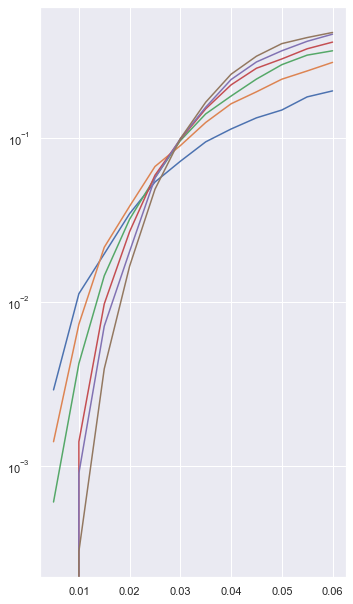

In [82]:
plt.yscale('log')
for i in range(len(code_distance_list)):
    plt.plot(error_prob_list,result[i])
plt.show()